# 2. Data Simulation

> **Purpose.** Generate synthetic price paths and option payoffs, then build **causal** per-timestep features for the hedger. The output of this notebook is the dataset consumed by Notebook 3 (training) and Notebook 4 (backtesting).

This includes underlying asset price paths, hedging instruments, and transaction costs.

---

## 2.1 Hedging Target: European Call Option

We define a **European call option** as our target derivative. This option gives the right, but not the obligation, to buy the underlying asset at a fixed strike price $( K )$ at maturity $( T )$.

### Payoff Function:

$$
Z_T = \max(S_T - K, 0)
$$

Where:
- $( S_T )$: the asset price at maturity
- $( K )$: the strike price

### Chosen Parameters:

- **Underlying Asset**: Single stock/index (simulated)
- **Strike Price** $( K )$: 100
- **Maturity** $( T )$: 1 year (252 trading days)
- **Initial Price** $( S_0 )$: 100

This means we are simulating a 1-year ATM (at-the-money) European call option.

---

In the next step, we simulate thousands of price paths for the underlying asset using Geometric Brownian Motion (GBM).

## 2.2 Simulating the Underlying Asset

We simulate many potential future paths for the underlying asset using **Geometric Brownian Motion (GBM)**, a widely used model in quantitative finance.

Each simulated path represents a possible market scenario — how the asset price could evolve over time, step by step.

### GBM Dynamics (Discrete Form):

$$
S_{t+\Delta t} = S_t \cdot \exp\left[\left(\mu - \frac{1}{2} \sigma^2\right) \Delta t + \sigma \sqrt{\Delta t} \cdot \varepsilon_t\right]
$$

Where:
- $( \mu )$: expected return (drift)
- $( \sigma )$: volatility
- $( \varepsilon_t \sim \mathcal{N}(0, 1) )$: random noise at time $( t )$
- $( \Delta t )$: time increment (1/252 for daily steps)

This produces **log-normally distributed prices** that are always positive.

---


## 2.3) High-level flow

1. **Choose model:** Geometric Brownian Motion (GBM) *or* Heston stochastic volatility.
2. **Simulate paths:** prices $(S_0,\dots,S_T)$ (and $(v_t)$ for Heston).
3. **Compute payoff:** $(Z_T)$ (here: European call with fixed strike $(K)$).
4. **Build causal features** per step $(t=0,\dots,T-1)$:
   - price normalization $(S_t/S_0)$
   - time to maturity proxy $(\tau_t=(T-t)/T)$
   - *lagged* log return: uses info up to $(t)$, not $(t{+}1)$
   - realized volatility (rolling window), annualized
5. **Derive $(\Delta S_t)$:** $(S_{t+1}-S_t)$ (aligned with features at time $(t)$).
6. **Split & save:** train/val/test arrays and a `meta.json` for reproducibility.

---

## 2.4) Configuration & reproducibility

- **Random seed** (e.g., 42) set once for all RNGs.
- **Data sizes:** `n_train`, `n_val`, `n_test`.
- **Time grid:** `T_years`, `n_steps`, `dt = T_years / n_steps`.
- **Option:** strike `K` (fixed in this project), risk-free `r` (we use `r = 0` here).
- **Output folders:** `data/` for arrays, `results/` for later notebooks.

In [1]:
import numpy as np
import json, os
from pathlib import Path
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Output dirs
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
VIZ_DIR  = Path("visualizations"); VIZ_DIR.mkdir(exist_ok=True)

# Choose model
toggle_bates = True   # False → GBM (+regimes/jumps), True → Bates

# Canonical placeholders (avoid stale globals)
S = None   # prices (n_paths, n_steps+1)
V = None   # variance paths for Bates (or None under GBM)

In [2]:
# Trading grid
S0 = 100.0
T  = 1.0
n_steps = 252
dt = T / n_steps

# Risk-neutral rates
r = 0.0
q = 0.0

# Paths per split
n_train, n_val, n_test = 8000, 5000, 5000

# Option and CVaR meta (for later notebooks)
K = 100.0
ALPHA = 0.95

In [3]:
# Long-run variance ~ (0.2)^2
theta = 0.04
v0    = 0.04
kappa = 3.0   # mean reversion
xi    = 0.4   # vol-of-vol (kept moderate; satisfies Feller with values above)
rho   = -0.7  # leverage
mu = 0.0
lambda_ = 10
m = -0.01
delta = 0.1

In [4]:
# Feller check (informational)
feller_lhs = 2 * kappa * theta
feller_rhs = xi**2
print(f"Feller check: 2*kappa*theta={feller_lhs:.4f} vs xi^2={feller_rhs:.4f}  → {'OK' if feller_lhs >= feller_rhs else 'violated'}")

Feller check: 2*kappa*theta=0.2400 vs xi^2=0.1600  → OK


In [5]:
def draw_correlated_normals(n_paths, n_steps, rho, rng):
    # Returns eps, eta ~ N(0,1) with Corr(eps,eta)=rho, each shape (n_paths, n_steps)
    Z = rng.standard_normal((2, n_paths, n_steps))
    L = np.array([[1.0, 0.0],[rho, np.sqrt(1 - rho**2)]])  # Cholesky for [[1,rho],[rho,1]]
    E = L @ Z.reshape(2, -1)
    eps = E[0].reshape(n_paths, n_steps)
    eta = E[1].reshape(n_paths, n_steps)
    return eps, eta

def call_payoff(ST, K):
    return np.maximum(ST - K, 0.0)

def summarize(S, name="S"):
    print(f"{name}: shape={S.shape}, S0≈{S[:,0].mean():.2f}, ST mean={S[:,-1].mean():.2f}, min={S.min():.2f}, max={S.max():.2f}")

## 2.5 Simulated Asset Price Paths (not used in this project)

Each path represents a possible trajectory of the asset price over 252 trading days, with:
- Initial price $( S_0 = 100 )$
- Drift $( \mu = 0\% )$
- Volatility $( \sigma = 20\% )$


To make our synthetic asset price data more reflective of real-world market behavior, we introduce three key enhancements to the basic Geometric Brownian Motion model:

---

### Volatility Spikes

We simulate short-lived bursts of extreme volatility to reflect sudden market stress, such as earnings reports or geopolitical news. Specifically:

- Each path receives one randomly placed volatility spike.
- The spike lasts for 5–15 consecutive days.
- During this period, volatility triples from 20% to 60%.

---

### Price Jumps

We inject rare but significant discrete jumps into the price paths to simulate sudden shocks (e.g. macroeconomic announcements or flash crashes):

- 20% of the paths include a single jump.
- The jump occurs randomly between day 30 and 240.
- Jump magnitudes range from ±5% to ±15%.

These jumps are applied directly to the price level, not the returns.

---

### Regime Switching

Each price path experiences structured volatility regime shifts:

- **Days 0–83**: Calm regime with volatility $( \sigma = 15\% )$
- **Days 84–167**: Crisis regime with volatility $( \sigma = 40\% )$
- **Days 168–251**: Recovery/normal regime with volatility $( \sigma = 20\% )$

This models longer-term structural changes in market behavior.

---

These enhancements significantly increase the realism of the simulated environment. They challenge the Deep Hedging model to adapt dynamically — improving robustness and generalization under real-world market frictions.


In [6]:
def simulate_gbm_paths(S0, r, q, sigma_const, n_paths, n_steps, dt, rng,
                       use_regimes=True, use_jumps=True):
    # Start from constant sigma; optionally overwrite with regimes/spikes
    sigma_matrix = np.full((n_paths, n_steps), sigma_const, dtype=float)
    if use_regimes:
        sigma_calm, sigma_volatile = 0.15, 0.40
        sigma_matrix[:, 0:84]   = sigma_calm
        sigma_matrix[:, 84:168] = sigma_volatile
        # Random spikes
        start_idx = rng.integers(50, min(200, n_steps - 5), size=n_paths)
        durations = rng.integers(5, 15, size=n_paths)
        for i in range(n_paths):
            s = start_idx[i]; e = min(s + durations[i], n_steps)
            sigma_matrix[i, s:e] = 3.0 * sigma_const

    eps = rng.standard_normal((n_paths, n_steps))
    log_ret = (r - q - 0.5 * sigma_matrix**2) * dt + sigma_matrix * np.sqrt(dt) * eps
    log_price = np.cumsum(log_ret, axis=1)
    rel_price = np.exp(log_price)
    S = S0 * np.hstack([np.ones((n_paths,1)), rel_price])

    if use_jumps:
        jump_matrix = np.zeros((n_paths, n_steps))
        # 20% chance for one jump per path
        mask = rng.random(n_paths) <= 0.2
        jump_t = rng.integers(30, n_steps-12, size=mask.sum())
        magn   = rng.uniform(0.05, 0.15, size=mask.sum())
        sign   = rng.choice([-1, 1], size=mask.sum())
        jump_matrix[mask, jump_t] = sign * magn
        S[:,1:] *= (1.0 + jump_matrix)  # apply after building price path

    return S  # (n_paths, n_steps+1)

### 2.6 Heston and Merton Diffusion (Bates) (used in this project)
- **SDEs:**
  $$
  \begin{aligned}
  dS_t &= (\mu - \lambda \kappa )S_t\,dt + \sqrt{v_t}\,S_t\,dW_t^{(S)} + S_{t^{-}}dJ_{t},\\
  dv_t &= \kappa(\theta - v_t)\,dt + \xi\sqrt{v_t}\,dW_t^{(v)},\\
  \mathrm{corr}(dW_t^{(S)}, dW_t^{(v)}) &= \rho.
  \end{aligned}
  $$
- **Discretization:** e.g., QE or full-truncation Euler to keep $(v_t \ge 0)$.
- **Parameters:** $(\kappa, \theta, \xi, \rho, v_0)$. Set $(r=\mu=0)$ here.
- **Poisson Jump Parameters:** $\lambda, k$

**Outputs**
- Prices: $(S \in \mathbb{R}^{N \times (n\_steps+1)})$ (include $(S_0)$).
- Variances (Heston): $(v \in \mathbb{R}^{N \times (n\_steps+1)})$ 

---

In [7]:
def simulate_bates_paths(S0, mu, q, v0, kappa, theta, xi, rho, lambda_, m, delta, n_paths, n_steps, dt, rng):
    S = np.empty((n_paths, n_steps+1), dtype=float)
    V = np.empty_like(S)
    S[:,0] = S0
    V[:,0] = max(v0, 0.0)

    eps, eta = draw_correlated_normals(n_paths, n_steps, rho, rng)

    # Jump compensator
    k = np.exp(m + 0.5 * delta**2) - 1.0
    drift_const = (r - q - lambda_ * k)
    
    for t in range(n_steps):
        vt = np.maximum(V[:,t], 0.0)
        # Variance update (Euler + truncation)
        V[:,t+1] = vt + kappa * (theta - vt) * dt + xi * np.sqrt(vt) * np.sqrt(dt) * eta[:,t]
        V[:,t+1] = np.maximum(V[:,t+1], 0.0)

        N_t = rng.poisson(lambda_ * dt, size=n_paths)
        jumps_log = rng.normal(loc=N_t * m, scale=np.sqrt(N_t) * delta)
        
        # Price update (risk-neutral)
        drift = (mu - q - lambda_ * k - 0.5 * vt) * dt
        diff  = np.sqrt(vt) * np.sqrt(dt) * eps[:, t]
        S[:, t+1] = S[:, t] * np.exp(drift + diff + jumps_log)
    

    return S, V

In [8]:
def make_split(n_paths_total, rng, sizes):
    # sizes = (n_train, n_val, n_test)
    idx = np.arange(n_paths_total)
    rng.shuffle(idx)
    n_tr, n_va, n_te = sizes
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:n_tr+n_va+n_te]

# Total paths to simulate once, then index splits
n_total = n_train + n_val + n_test

if toggle_bates:
    S_full, V_full = simulate_bates_paths(S0, mu, q, v0, kappa, theta, xi, rho, lambda_, m, delta,n_total, n_steps, dt, rng)
    V = V_full
else:
    S_full = simulate_gbm_paths(S0, r, q, 0.20, n_total, n_steps, dt, rng, use_regimes=True, use_jumps=True)
    V = None

S = S_full
assert S.shape == (n_total, n_steps+1), S.shape
if toggle_bates:
    assert V.shape == (n_total, n_steps+1), V.shape

idx_tr, idx_va, idx_te = make_split(n_total, rng, (n_train, n_val, n_test))
S_train, S_val, S_test = S[idx_tr], S[idx_va], S[idx_te]
V_train = V_val = V_test = None
if toggle_bates:
    V_train, V_val, V_test = V[idx_tr], V[idx_va], V[idx_te]

# Payoffs
Z_T_train = call_payoff(S_train[:,-1], K)
Z_T_val   = call_payoff(S_val[:,-1],   K)
Z_T_test  = call_payoff(S_test[:,-1],  K)

summarize(S_train, "S_train")
if toggle_bates: summarize(V_train, "V_train")

S_train: shape=(8000, 253), S0≈100.00, ST mean=99.92, min=16.82, max=466.61
V_train: shape=(8000, 253), S0≈0.04, ST mean=0.04, min=0.00, max=0.33


In [9]:
# Canonical, branch-agnostic log returns (model will recompute from raw S too)
logR_train = np.diff(np.log(S_train), axis=1)
logR_val   = np.diff(np.log(S_val),   axis=1)
logR_test  = np.diff(np.log(S_test),  axis=1)

print("logR_train shape:", logR_train.shape)  # (n_train, n_steps)

logR_train shape: (8000, 252)


In [10]:
np.save(DATA_DIR/"S_train_b.npy", S_train)
np.save(DATA_DIR/"S_val_b.npy",   S_val)
np.save(DATA_DIR/"S_test_b.npy",  S_test)

if toggle_bates:
    np.save(DATA_DIR/"V_train_b.npy", V_train)
    np.save(DATA_DIR/"V_val_b.npy",   V_val)
    np.save(DATA_DIR/"V_test_b.npy",  V_test)

np.save(DATA_DIR/"Z_T_train_b.npy", Z_T_train)
np.save(DATA_DIR/"Z_T_val_b.npy",   Z_T_val)
np.save(DATA_DIR/"Z_T_test_b.npy",  Z_T_test)

meta = {
    "market_model": "bates" if toggle_bates else "gbm",
    "S0": S0, "K": K, "T": T, "n_steps": n_steps, "dt": dt,
    "r": r, "q": q, "alpha": ALPHA, "seed": SEED,
    "n_train": n_train, "n_val": n_val, "n_test": n_test
}
if not toggle_bates:
    meta["gbm"] = {"sigma": 0.20, "regimes": True, "jumps": True}
else:
    meta["bates"] = {"theta": theta, "v0": v0, "kappa": kappa, "xi": xi, "rho": rho}

with open(DATA_DIR/"meta_b.json", "w") as f:
    json.dump(meta, f, indent=2)

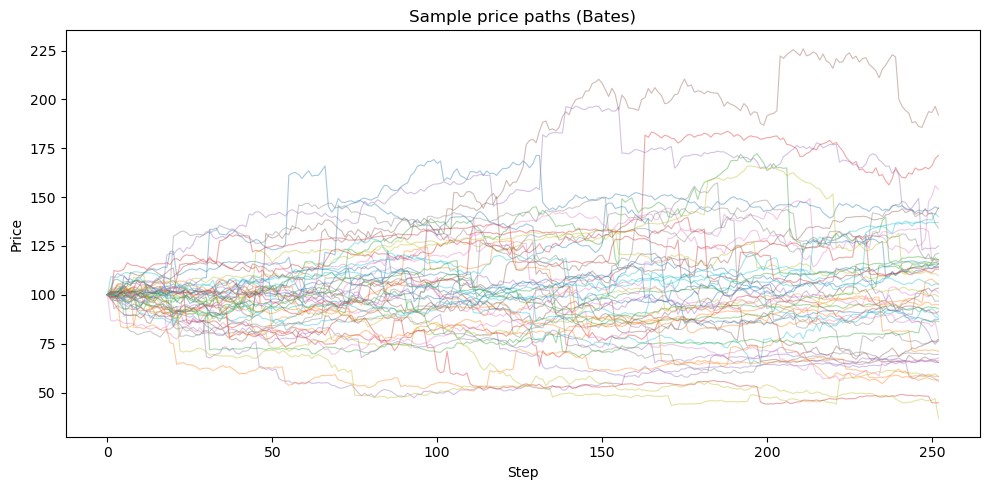

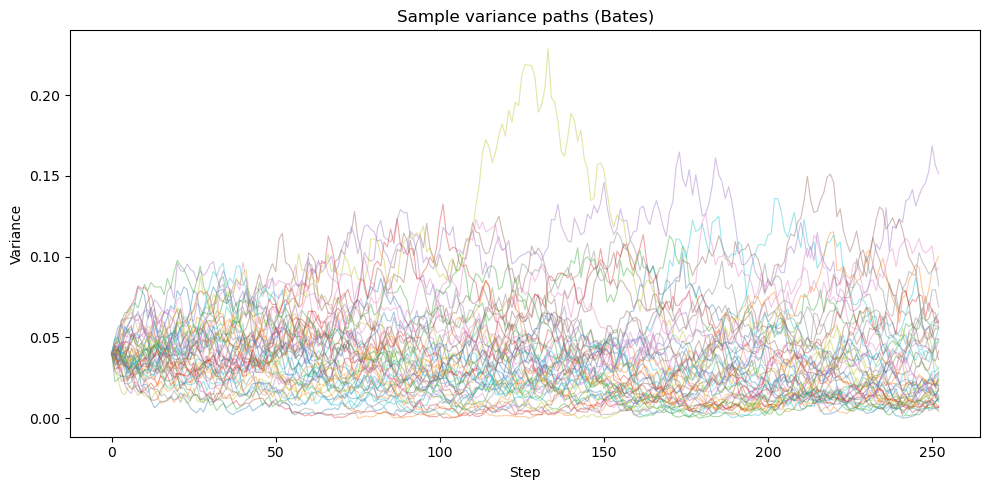

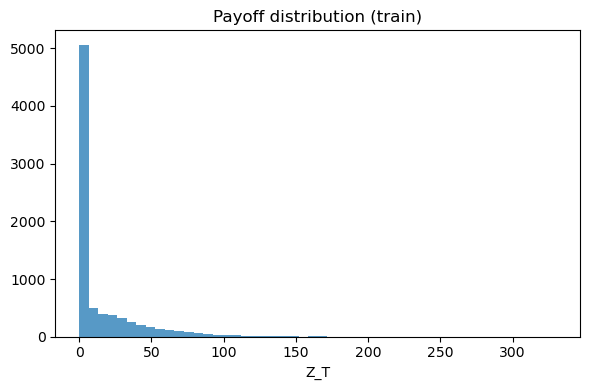

In [11]:
plt.figure(figsize=(10,5))
for i in range(min(50, len(S_train))):
    plt.plot(S_train[i], alpha=0.4, lw=0.8)
plt.title(f"Sample price paths ({'Bates' if toggle_bates else 'GBM'})")
plt.xlabel("Step"); plt.ylabel("Price"); plt.tight_layout()
plt.savefig(VIZ_DIR/"train_price_paths.png", dpi=150); plt.show()

if toggle_bates:
    plt.figure(figsize=(10,5))
    for i in range(min(50, len(V_train))):
        plt.plot(V_train[i], alpha=0.4, lw=0.8)
    plt.title("Sample variance paths (Bates)")
    plt.xlabel("Step"); plt.ylabel("Variance"); plt.tight_layout()
    plt.savefig(VIZ_DIR/"train_variance_paths_b.png", dpi=150); plt.show()

plt.figure(figsize=(6,4))
plt.hist(Z_T_train, bins=50, alpha=0.75)
plt.title("Payoff distribution (train)")
plt.xlabel("Z_T"); plt.tight_layout()
plt.savefig(VIZ_DIR/"train_payoff_hist_b.png", dpi=150); plt.show()

In [12]:
print("=== Interface ===")
print("Model:", "Bates" if toggle_bates else "GBM")
print("S shapes:", S_train.shape, S_val.shape, S_test.shape)
print("V present:", toggle_bates)
if toggle_bates:
    print("V shapes:", V_train.shape, V_val.shape, V_test.shape)
print("Z_T shapes:", Z_T_train.shape, Z_T_val.shape, Z_T_test.shape)

=== Interface ===
Model: Bates
S shapes: (8000, 253) (5000, 253) (5000, 253)
V present: True
V shapes: (8000, 253) (5000, 253) (5000, 253)
Z_T shapes: (8000,) (5000,) (5000,)


## 2.7) Deliverables (from this notebook)

- `data/S_train.npy`, `S_val.npy`, `S_test.npy`
- `data/Z_T_train.npy`, `Z_T_val.npy`, `Z_T_test.npy`
- `data/meta.json` (all knobs)